# Gradient Accumulation Project 
The following blocks of code are part of a research project investigating the effectiveness of using gradient accumulation to enhance neural network learning. With this code my aim is to show that taking one "big" step across the entire data set may prove to be beneficial in several specific contexts. My goals is to create two identical models and only compare the different training apporoaches and results. It is important to note that the code below only serves as the exploratory first steps of this research project. It is also worth noting, that while PyTorch already provides this functionality, Tensorflow & Keras do not. Therefore, this implementation may possibly be integrated into a future version of the Keras library. 

## Import Relevant Packages
These packages can either be pre-installed directly by the user, or the user can opt to use the poetry package to install the project's dependencies. To use poetry, first run: "poetry install --no-root", then run "poetry shell" to activate the virtual environment in which to run this notebook. 

In [1]:
import tensorflow as tf
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
#from micrograd.engine import Value 
from tensorflow import keras as keras
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense


If you are running this notebook on an Apple silicon chip (M1/M2), please make sure that TensorFlow has GPU access (not absolutely necessary, but it does improve training performance).

In [2]:
# Check for TensorFlo£w GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load the Data
Now, the first step is to load our data. For simplicity, we will be using data sets that Keras provides us, specifically MNIST & Fashion-MNIST.  

In [3]:
# Decide what batch size you want to train the models with
batch_size = 512

# Load and preprocess the standard MNIST data
mnist = keras.datasets.mnist
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()
X_train_mnist = X_train_mnist / 255.0
X_test_mnist = X_test_mnist / 255.0

# Create the MNIST dataset
data_mnist = tf.data.Dataset.from_tensor_slices((X_train_mnist, y_train_mnist)).batch(batch_size)


# Load and preprocess the Fashion MNIST data
fashion_mnist = keras.datasets.fashion_mnist
(X_train_fashion, y_train_fashion), (X_test_fashion, y_test_fashion) = fashion_mnist.load_data()
X_train_fashion = X_train_fashion / 255.0
X_test_fashion = X_test_fashion / 255.0

# Create the Fashion MNIST dataset
data_fashion = tf.data.Dataset.from_tensor_slices((X_train_fashion, y_train_fashion)).batch(batch_size)

2023-12-22 12:07:44.691296: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-12-22 12:07:44.691319: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-22 12:07:44.691329: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-22 12:07:44.691543: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-22 12:07:44.692349: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Let's take a look at an example image of both of our data sets. To do so, we will need to visualize the arrays using matplotlib. 

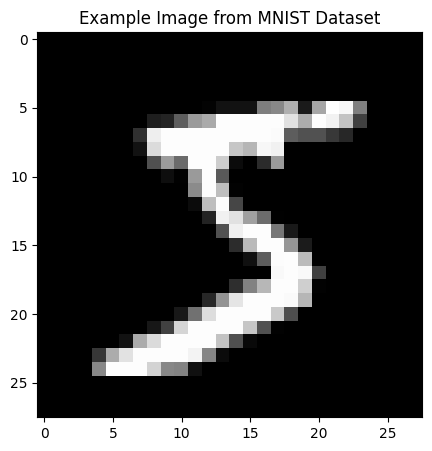

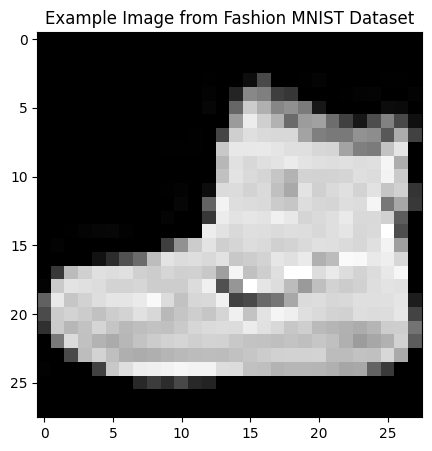

In [4]:

# Plot an example image from the MNIST dataset
plt.figure(figsize=(5,5))
plt.imshow(X_train_mnist[0], cmap='gray')
plt.title('Example Image from MNIST Dataset')
plt.show()

# Plot an example image from the Fashion MNIST dataset
plt.figure(figsize=(5,5))
plt.imshow(X_train_fashion[0], cmap='gray')
plt.title('Example Image from Fashion MNIST Dataset')
plt.show()


It looks like the first image should be the digit "5", although it looks very much like an "S". The second image seems to be a shoe, specifically a boot. Please note that we would normally explore out data set further to get to know the intricacies of it. However, since these are two of the most commonly used data sets, I will not spend more time exploring them here. 

# Create the Models
Here we create the two models we will be using. In order to make sure they have the same initial weights, we need to set a seed. For the model, I have decided to use 3 Dense layers with the number of neurons descending in half steps, until finally arriving at the output/prediction layer with 10 neurons, representing the number of classes in both data sets. This is common practice, since deeper layers will learn more abstract patterns, after the first layer learns more "holistically". Also since the size of our training set is 60'000, we ideally would like to have between 60'000-150'000 parameters in our model - 1/4-1/10 of total possible option space (600'000). Here our model has exactly 111'146 parameters.  

In [37]:
# Define a function to create the model
def create_model():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),
        keras.layers.Dense(128, activation='tanh'),
        keras.layers.Dense(64, activation='tanh'),
        keras.layers.Dense(32, activation='tanh'),
        keras.layers.Dense(10, activation='linear')
    ])
    return model

# Set the seed
tf.random.set_seed(42)

# Create the standard model
s_model = create_model()

# Create the accumulation model
a_model = create_model()

s_model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 784)               0         
                                                                 
 dense_56 (Dense)            (None, 128)               100480    
                                                                 
 dense_57 (Dense)            (None, 64)                8256      
                                                                 
 dense_58 (Dense)            (None, 32)                2080      
                                                                 
 dense_59 (Dense)            (None, 10)                330       
                                                                 
Total params: 111146 (434.16 KB)
Trainable params: 111146 (434.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Next we define the loss function and the optimizer. We use the Adam optimizer with a learning rate of 0.01 and the sparse categorical crossentropy loss function. Please note that for the purposes of this research project, the model and its optimizers, loss functions, activation functions etc. are irrelevant, as we are only interested in comparing the training approaches with each other. As long as both models are identical, we can draw a fair comparison. 

In [38]:
# Define the optimizer 
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate = 0.01)

# Explicitly define loss function with (logits = True) because we are not using softmax activation in the final layer
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

s_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

a_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Train Standard Model 
Now we move on the training. Since we want to do this step more or less completely manually, while still tracking relevant metrics, it requires a lengthy set-up. We first create the variables that will track our metrics. We then decide on how many epochs we want to train for. Feel free to adjust this based on how long you wish to train the model on your local machine. The default it is set to is 200 epochs as that gives us a good approximation. 

In [40]:
# Initialize lists to store metrics
train_losses_standard = []
val_losses_standard = []
train_accuracies_standard = []
val_accuracies_standard = []

# Number of epochs to train for
num_epochs = 200

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Initialize lists to store metrics for each batch
    batch_losses = []
    batch_accuracies = []

    # Iterate over the batches of the dataset
    for step, (X_batch, y_batch) in enumerate(data_mnist):
        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = s_model(X_batch, training=True)
            # Compute the loss value
            loss_value = loss_fn(y_batch, y_pred)

        # Compute gradients
        grads = tape.gradient(loss_value, s_model.trainable_weights)

        # Update weights
        optimizer.apply_gradients(zip(grads, s_model.trainable_weights))
        

        # Store metrics for this batch
        batch_losses.append(loss_value.numpy())
        batch_accuracies.append(tf.reduce_mean(tf.cast(tf.equal(tf.cast(y_batch, tf.int64), tf.argmax(y_pred, axis=1)), tf.float32)).numpy())
        
    
    # Compute average metrics for this epoch
    train_loss = np.mean(batch_losses)
    train_accuracy = np.mean(batch_accuracies)
    train_losses_standard.append(train_loss)
    train_accuracies_standard.append(train_accuracy)

    # Compute validation metrics for this epoch
    y_val_pred = s_model(X_test_mnist, training=False)
    val_loss = np.mean(loss_fn(y_test_mnist, y_val_pred).numpy())
    val_accuracy = np.mean(tf.cast(tf.equal(y_test_mnist, tf.argmax(y_val_pred, axis=1)), tf.float32).numpy())
    val_losses_standard.append(val_loss)
    val_accuracies_standard.append(val_accuracy)

    # Log metrics at the end of each epoch
    print(f"Training loss for epoch {epoch+1}: {train_loss}")
    print(f"Training accuracy for epoch {epoch+1}: {train_accuracy}")
    print(f"Validation loss for epoch {epoch+1}: {val_loss}")
    print(f"Validation accuracy for epoch {epoch+1}: {val_accuracy}")


Epoch 1/200
Training loss for epoch 1: 1.639849305152893
Training accuracy for epoch 1: 0.5337713956832886
Validation loss for epoch 1: 1.2186195850372314
Validation accuracy for epoch 1: 0.7346000075340271
Epoch 2/200
Training loss for epoch 2: 1.0583500862121582
Training accuracy for epoch 2: 0.7658015489578247
Validation loss for epoch 2: 0.9000820517539978
Validation accuracy for epoch 2: 0.8077999949455261
Epoch 3/200
Training loss for epoch 3: 0.8312516212463379
Training accuracy for epoch 3: 0.8174269795417786
Validation loss for epoch 3: 0.7373012900352478
Validation accuracy for epoch 3: 0.8420000076293945
Epoch 4/200
Training loss for epoch 4: 0.7018334865570068
Training accuracy for epoch 4: 0.8442245125770569
Validation loss for epoch 4: 0.6351539492607117
Validation accuracy for epoch 4: 0.8636000156402588
Epoch 5/200
Training loss for epoch 5: 0.616486132144928
Training accuracy for epoch 5: 0.8611571192741394
Validation loss for epoch 5: 0.5647680759429932
Validation acc

# Gradient Accumulation Model

In [41]:
# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Number of epochs to train for
num_epochs = 200

# Initialize accumulators
accumulated_grads = [tf.zeros_like(w) for w in a_model.trainable_weights]

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Initialize lists to store metrics for each batch
    batch_losses = []
    batch_accuracies = []

    # Iterate over the batches of the dataset
    for step, (X_batch, y_batch) in enumerate(data_mnist):
        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = a_model(X_batch, training=True)
            # Compute the loss value
            loss_value = loss_fn(y_batch, y_pred)

        # Compute gradients - backward pass
        grads = tape.gradient(loss_value, a_model.trainable_weights)

            # If it's the final batch, adjust the gradients
        if (step + 1) == len(data_mnist):
            final_batch_size = len(X_batch)
            grads = [g * final_batch_size / batch_size for g in grads]

        # Accumulate gradients
        accumulated_grads = [acc_g + g for acc_g, g in zip(accumulated_grads, grads)]

        # Store metrics for this batch
        batch_losses.append(loss_value.numpy())
        batch_accuracies.append(tf.reduce_mean(tf.cast(tf.equal(tf.cast(y_batch, tf.int64), tf.argmax(y_pred, axis=1)), tf.float32)))

    # Normalize the accumulated gradients
    accumulated_grads = [acc_g / len(data_mnist) for acc_g in accumulated_grads]
    
    # Update weights after all batches are processed
    optimizer.apply_gradients(zip(accumulated_grads, a_model.trainable_weights))

    # Compute average metrics for this epoch
    avg_train_loss = np.mean(batch_losses)
    avg_train_accuracy = np.mean(batch_accuracies)

    # Print the loss and accuracy for each epoch
    print(f"Training loss for epoch {epoch+1}: {avg_train_loss}")
    print(f"Training accuracy for epoch {epoch+1}: {avg_train_accuracy}")

    # Append average metrics for this epoch
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    # Compute validation metrics for this epoch
    y_val_pred = a_model(X_test_mnist, training=False)
    val_loss = np.mean(loss_fn(y_test_mnist, y_val_pred).numpy())
    val_accuracy = np.mean(tf.cast(tf.equal(y_test_mnist, tf.argmax(y_val_pred, axis=1)), tf.float32).numpy())

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Reset the accumulators for the next epoch
    accumulated_grads = [tf.zeros_like(w) for w in a_model.trainable_weights]


Epoch 1/200
Training loss for epoch 1: 2.3934335708618164
Training accuracy for epoch 1: 0.11590748280286789
Epoch 2/200
Training loss for epoch 2: 2.368044853210449
Training accuracy for epoch 2: 0.12971177697181702
Epoch 3/200
Training loss for epoch 3: 2.343747615814209
Training accuracy for epoch 3: 0.14344985783100128
Epoch 4/200
Training loss for epoch 4: 2.320418357849121
Training accuracy for epoch 4: 0.15730932354927063
Epoch 5/200
Training loss for epoch 5: 2.2979559898376465
Training accuracy for epoch 5: 0.17137844860553741
Epoch 6/200
Training loss for epoch 6: 2.2762787342071533
Training accuracy for epoch 6: 0.185618594288826
Epoch 7/200
Training loss for epoch 7: 2.2553164958953857
Training accuracy for epoch 7: 0.20054841041564941
Epoch 8/200
Training loss for epoch 8: 2.2350122928619385
Training accuracy for epoch 8: 0.21458442509174347
Epoch 9/200
Training loss for epoch 9: 2.2153170108795166
Training accuracy for epoch 9: 0.22819562256336212
Epoch 10/200
Training lo

# Visualize Results & Compare Different Approaches

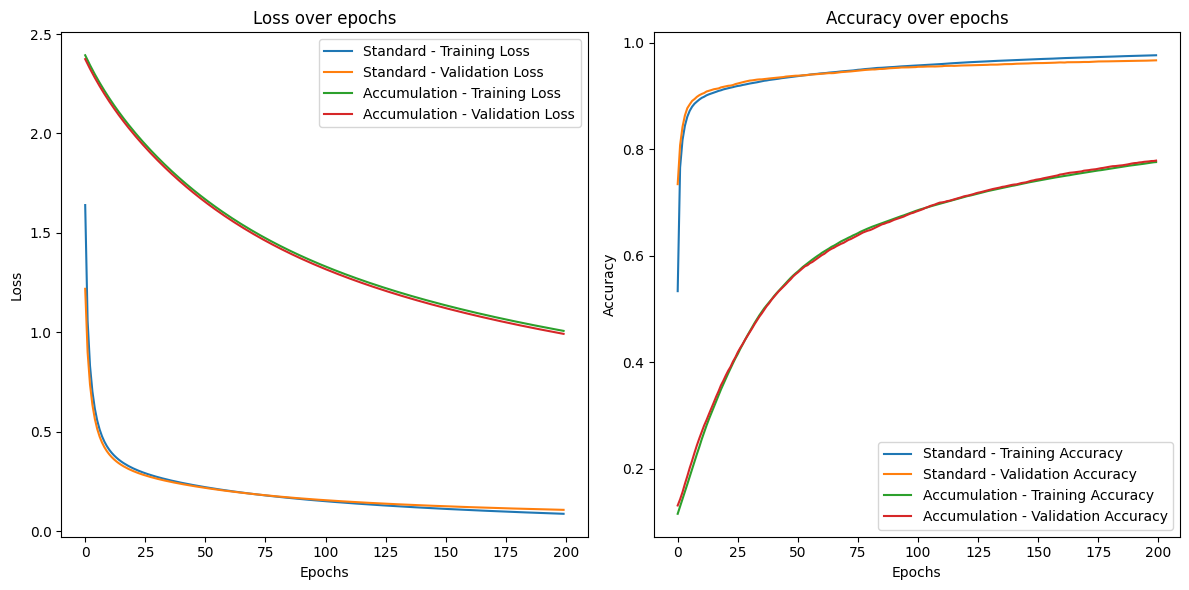

In [42]:

# Plot training and validation loss over each epoch
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses_standard, label='Standard - Training Loss')
plt.plot(val_losses_standard, label='Standard - Validation Loss')
plt.plot(train_losses, label='Accumulation - Training Loss')
plt.plot(val_losses, label='Accumulation - Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy over each epoch
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_standard, label='Standard - Training Accuracy')
plt.plot(val_accuracies_standard, label='Standard - Validation Accuracy')
plt.plot(train_accuracies, label='Accumulation - Training Accuracy')
plt.plot(val_accuracies, label='Accumulation - Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix & Classification Report

313/313 [==============================] - 1s 2ms/step


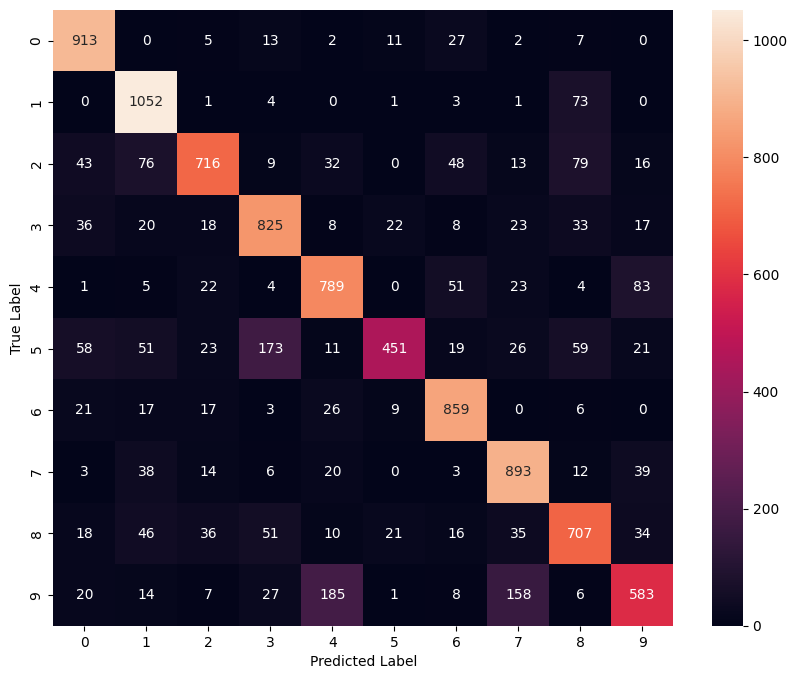

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       980
           1       0.80      0.93      0.86      1135
           2       0.83      0.69      0.76      1032
           3       0.74      0.82      0.78      1010
           4       0.73      0.80      0.76       982
           5       0.87      0.51      0.64       892
           6       0.82      0.90      0.86       958
           7       0.76      0.87      0.81      1028
           8       0.72      0.73      0.72       974
           9       0.74      0.58      0.65      1009

    accuracy                           0.78     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.78      0.77     10000



In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

# Predict the values from the validation dataset
y_pred = a_model.predict(X_test_mnist)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test_mnist, y_pred_classes) 

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print(classification_report(y_test_mnist, y_pred_classes))

# Fashion MNIST Version

In [44]:
# First we need to create a new model with the same starting weights 

# Set the seed
tf.random.set_seed(42)

# Create the standard model
s2_model = create_model()

# Create the accumulation model
a2_model = create_model()

# We will use the same optimizer and loss function as before

s2_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

a2_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [45]:
# Initialize lists to store metrics
train_losses_standard_fashion = []
val_losses_standard_fashion = []
train_accuracies_standard_fashion = []
val_accuracies_standard_fashion = []

# Number of epochs to train for
num_epochs = 200

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Initialize lists to store metrics for each batch
    batch_losses = []
    batch_accuracies = []

    # Iterate over the batches of the dataset
    for step, (X_batch, y_batch) in enumerate(data_fashion):
        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = s2_model(X_batch, training=True)
            # Compute the loss value
            loss_value = loss_fn(y_batch, y_pred)

        # Compute gradients
        grads = tape.gradient(loss_value, s2_model.trainable_weights)

        # Update weights
        optimizer.apply_gradients(zip(grads, s2_model.trainable_weights))
        
        # Log metrics at the end of each epoch
        if step == len(data_fashion) - 1:
            train_loss = np.mean(batch_losses)
            train_accuracy = np.mean(batch_accuracies)
            print(f"Training loss for epoch {epoch+1}: {train_loss}")
            print(f"Training accuracy for epoch {epoch+1}: {train_accuracy}")

        # Store metrics for this batch
        batch_losses.append(loss_value.numpy())
        batch_accuracies.append(tf.reduce_mean(tf.cast(tf.equal(tf.cast(y_batch, tf.int64), tf.argmax(y_pred, axis=1)), tf.float32)).numpy())
        
    # Compute average metrics for this epoch
    train_losses_standard_fashion.append(np.mean(batch_losses))
    train_accuracies_standard_fashion.append(np.mean(batch_accuracies))

    # Compute validation metrics for this epoch
    y_val_pred = s2_model(X_test_fashion, training=False)
    val_loss = np.mean(loss_fn(y_test_fashion, y_val_pred).numpy())
    val_accuracy = np.mean(tf.cast(tf.equal(y_test_fashion, tf.argmax(y_val_pred, axis=1)), tf.float32).numpy())

    val_losses_standard_fashion.append(val_loss)
    val_accuracies_standard_fashion.append(val_accuracy)


Epoch 1/200
Training loss for epoch 1: 1.6180275678634644
Training accuracy for epoch 1: 0.47863247990608215
Epoch 2/200
Training loss for epoch 2: 1.1347659826278687
Training accuracy for epoch 2: 0.674195408821106
Epoch 3/200
Training loss for epoch 3: 0.9393534064292908
Training accuracy for epoch 3: 0.7248430848121643
Epoch 4/200
Training loss for epoch 4: 0.8261443972587585
Training accuracy for epoch 4: 0.7475460767745972
Epoch 5/200
Training loss for epoch 5: 0.753303587436676
Training accuracy for epoch 5: 0.7630375027656555
Epoch 6/200
Training loss for epoch 6: 0.7021108269691467
Training accuracy for epoch 6: 0.7747395634651184
Epoch 7/200
Training loss for epoch 7: 0.6635023951530457
Training accuracy for epoch 7: 0.7841880321502686
Epoch 8/200
Training loss for epoch 8: 0.6328722834587097
Training accuracy for epoch 8: 0.7921174168586731
Epoch 9/200
Training loss for epoch 9: 0.6077283620834351
Training accuracy for epoch 9: 0.7995793223381042
Epoch 10/200
Training loss fo

# Accumulation Model 

In [46]:
# Initialize lists to store metrics
a_train_losses_fashion = []
a_val_losses_fashion = []
a_train_accuracies_fashion = []
a_val_accuracies_fashion = []

# Number of epochs to train for
num_epochs = 200

# Initialize accumulators
accumulated_grads = [tf.zeros_like(w) for w in a2_model.trainable_weights]

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Initialize lists to store metrics for each batch
    batch_losses = []
    batch_accuracies = []

    # Iterate over the batches of the dataset
    for step, (X_batch, y_batch) in enumerate(data_fashion):
        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = a2_model(X_batch, training=True)
            # Compute the loss value
            loss_value = loss_fn(y_batch, y_pred)

        # Compute gradients - backward pass
        grads = tape.gradient(loss_value, a2_model.trainable_weights)

            # If it's the final batch, adjust the gradients
        if (step + 1) == len(data_fashion):
            final_batch_size = len(X_batch)
            grads = [g * final_batch_size / batch_size for g in grads]

        # Accumulate gradients
        accumulated_grads = [acc_g + g for acc_g, g in zip(accumulated_grads, grads)]

        # Store metrics for this batch
        batch_losses.append(loss_value.numpy())
        batch_accuracies.append(tf.reduce_mean(tf.cast(tf.equal(tf.cast(y_batch, tf.int64), tf.argmax(y_pred, axis=1)), tf.float32)))

    # Normalize the accumulated gradients
    accumulated_grads = [acc_g / len(data_fashion) for acc_g in accumulated_grads]
    
    # Update weights after all batches are processed
    optimizer.apply_gradients(zip(accumulated_grads, a2_model.trainable_weights))

    # Compute average metrics for this epoch
    avg_train_loss = np.mean(batch_losses)
    avg_train_accuracy = np.mean(batch_accuracies)

    # Print the loss and accuracy for each epoch
    print(f"Training loss for epoch {epoch+1}: {avg_train_loss}")
    print(f"Training accuracy for epoch {epoch+1}: {avg_train_accuracy}")

    # Append average metrics for this epoch
    a_train_losses_fashion.append(avg_train_loss)
    a_train_accuracies_fashion.append(avg_train_accuracy)

    # Compute validation metrics for this epoch
    y_val_pred = a2_model(X_test_fashion, training=False)
    val_loss = np.mean(loss_fn(y_test_fashion, y_val_pred).numpy())
    val_accuracy = np.mean(tf.cast(tf.equal(y_test_fashion, tf.argmax(y_val_pred, axis=1)), tf.float32).numpy())

    a_val_losses_fashion.append(val_loss)
    a_val_accuracies_fashion.append(val_accuracy)

    # Reset the accumulators for the next epoch
    accumulated_grads = [tf.zeros_like(w) for w in a2_model.trainable_weights]


Epoch 1/200
Training loss for epoch 1: 2.310701608657837
Training accuracy for epoch 1: 0.0833829864859581
Epoch 2/200
Training loss for epoch 2: 2.2763760089874268
Training accuracy for epoch 2: 0.08476783335208893
Epoch 3/200
Training loss for epoch 3: 2.2461938858032227
Training accuracy for epoch 3: 0.09358447790145874
Epoch 4/200
Training loss for epoch 4: 2.218925952911377
Training accuracy for epoch 4: 0.10981086641550064
Epoch 5/200
Training loss for epoch 5: 2.1937613487243652
Training accuracy for epoch 5: 0.13298353552818298
Epoch 6/200
Training loss for epoch 6: 2.170168161392212
Training accuracy for epoch 6: 0.15806519985198975
Epoch 7/200
Training loss for epoch 7: 2.147792339324951
Training accuracy for epoch 7: 0.18788620829582214
Epoch 8/200
Training loss for epoch 8: 2.1263937950134277
Training accuracy for epoch 8: 0.21815964579582214
Epoch 9/200
Training loss for epoch 9: 2.105804920196533
Training accuracy for epoch 9: 0.2469213455915451
Epoch 10/200
Training loss

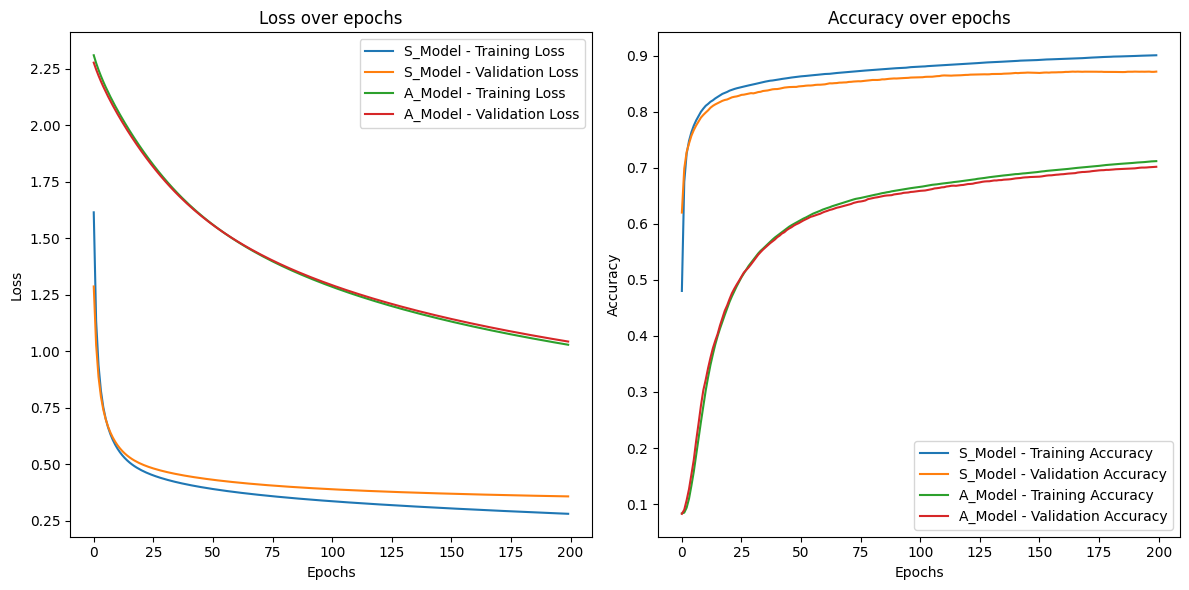

In [47]:

# Plot training and validation loss over each epoch
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses_standard_fashion, label='S_Model - Training Loss')
plt.plot(val_losses_standard_fashion, label='S_Model - Validation Loss')
plt.plot(a_train_losses_fashion, label='A_Model - Training Loss')
plt.plot(a_val_losses_fashion, label='A_Model - Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_standard_fashion, label='S_Model - Training Accuracy')
plt.plot(val_accuracies_standard_fashion, label='S_Model - Validation Accuracy')
plt.plot(a_train_accuracies_fashion, label='A_Model - Training Accuracy')
plt.plot(a_val_accuracies_fashion, label='A_Model - Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



313/313 [==============================] - 1s 2ms/step


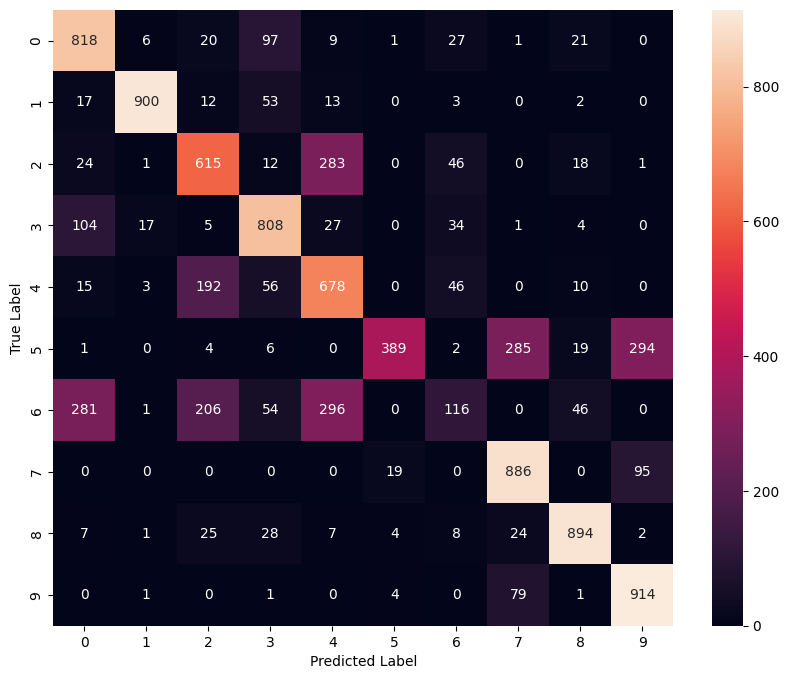

              precision    recall  f1-score   support

           0       0.65      0.82      0.72      1000
           1       0.97      0.90      0.93      1000
           2       0.57      0.61      0.59      1000
           3       0.72      0.81      0.76      1000
           4       0.52      0.68      0.59      1000
           5       0.93      0.39      0.55      1000
           6       0.41      0.12      0.18      1000
           7       0.69      0.89      0.78      1000
           8       0.88      0.89      0.89      1000
           9       0.70      0.91      0.79      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.68     10000
weighted avg       0.70      0.70      0.68     10000



In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

# Predict the values from the validation dataset
y_pred = a2_model.predict(X_test_fashion)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test_fashion, y_pred_classes) 

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print(classification_report(y_test_fashion, y_pred_classes))

# Discussion of Results 
The visualizations of the loss and accuracy curves show us that both training approaches across both data sets result in different "learning styles". We can see that the standard model seems to learn very quickly, and performs very well on both the training and validation data. In comparison, the accumulation model learns at a slower, yet very consistent rate, and also shows a similar performance on both the training and validation data. This is as expected because the standard model simply has more optimization steps (every batch) compared to one optimization step every epoch with the accumulation model. The smooth curves tell us that the training process is stable and since there is basically no divergence between training and validation data, the model is far from overfitting. Overall, both models are training normally, and the graphs look as expected. Obviously it is worth pointing out that the standard model performs better overall (lower cost and higher accuracy). However, the fact that the gradient accumulation approach also gives us a good result is promising. 